In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
# surf=xr.open_dataset(paths['mask'],decode_times=False).coast_mask[0,1,:,:]
# fig,ax=plt.subplots(1,1,figsize=(5,10))
# ax.contour(surf)
# ax.set_aspect(1/np.sin(np.deg2rad(49)))

In [2]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/SalishSea.yaml'

In [3]:
param = load_config1(config)
start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
Tmax = param['param']['length'] # Set Time length [days] 
duration = timedelta(days=Tmax)
dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
N = param['param']['N'] # number of deploying locations
n = param['param']['n'] # 1000   # number of particles per location
dmin = param['param']['dmin'] #minimum depth
dd = param['param']['dd'] #max depth difference from dmin
name = param['file']['name'] #name output file

#WS = param['particle']['Ws']

daterange = [start+timedelta(days=i) for i in range(Tmax)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [4]:
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [5]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

In [54]:
#ds = xr.open_dataset('/results2/SalishSea/nowcast-green.201905/01jun21/SalishSea_1d_20210601_20210601_ptrc_T.nc')

In [6]:
DS=ds.to_dataframe()

DSsed=DS[DS.beached==3.0]
DSbe=DS[DS.beached==1.0]
DScol=DS[DS.beached==0.0]

Sedlon=np.array(DSsed.iloc[:,0])#.sort_values(by='time')
Seddepth=np.array(DSsed.iloc[:,2])#.sort_values(by='time')
Sedlat=np.array(DSsed.iloc[:,1])#.sort_values(by='time')

Belon=np.array(DSbe.iloc[:,0])#.sort_values(by='time')
Belat=np.array(DSbe.iloc[:,1])#.sort_values(by='time')

Collon=np.array(DScol.iloc[:,0])#.sort_values(by='time')
Collat=np.array(DScol.iloc[:,1])#.sort_values(by='time')

In [7]:
def distancia(lat2,lon2):
    R = 6371e3
    la1 = float(outf_lat) * math.pi/180
    la2 = lat2 * math.pi/180
    deltlat = (lat2-float(outf_lat)) * math.pi/180
    deltlon = (lon2-float(outf_lon)) * math.pi/180
    a = np.sin(deltlat/2) * np.sin(deltlat/2) + np.cos(la1) * np.cos(la2) * np.sin(deltlon/2) * np.sin(deltlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c 

def age_mf(subdat):
    AA = False
    ii = 0
    cc = 0
    count = []
    index = []
    while AA == False: 
        try:
            count.append(subdat.tau[:,ii].count())
            index.append(ii)
            ii += 1
        except KeyError:
            cc += 1
            ii += 1
            if cc > 10:
                AA = True
    return count,index
            
count,index = age_mf(DScol)

In [9]:
time= np.array(DS.time[0,:])

In [10]:
countime = [] 
countime1 = [] 
countime2 = [] 
for t in time:
    countime.append(len(DScol.time[DScol.time==t]))
    countime1.append(len(DSsed.time[DSsed.time==t]))
    countime2.append(len(DSbe.time[DSbe.time==t]))
#np.savetxt("time_2.csv", countime, delimiter=",")
#countime=np.genfromtxt('time0.csv', delimiter=',')
#countime1=np.genfromtxt('time1.csv', delimiter=',')
#countime2=np.genfromtxt('time_2.csv', delimiter=',')

In [11]:
countime2[-1]/(countime[-1]+countime2[-1]+countime1[-1])

0.3451345543845288

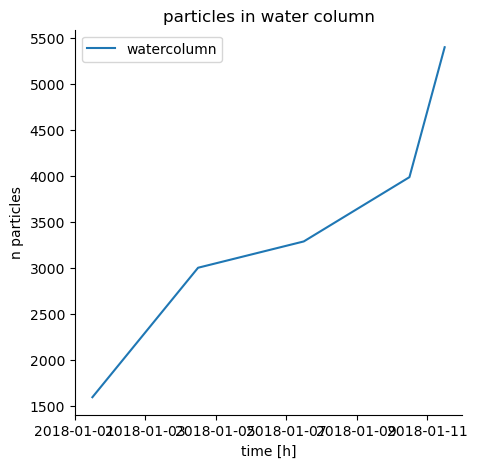

In [12]:
Time=np.linspace(0,120,28810)
fig,ax=plt.subplots(1,figsize=(5,5))
plt.plot(time,countime,label='watercolumn')
#plt.plot(time,countime1,label='sediment')
#plt.plot(time,countime2,label='beached')
plt.legend()
plt.xlabel('time [h]')
plt.ylabel('n particles')
plt.title('particles in water column')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

Text(0.5, 1.0, 'Particles beached')

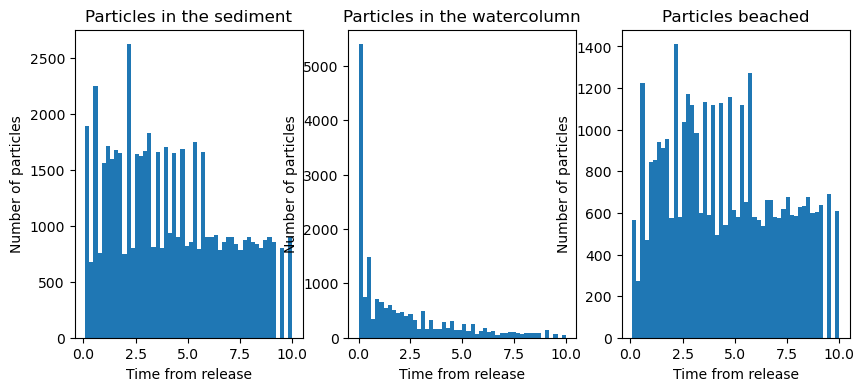

In [13]:
fig,axs=plt.subplots(1,3,figsize=(10,4))
axs[0].hist(DSsed.tau/86400, bins = 50)
axs[0].set_xlabel('Time from release')
axs[0].set_ylabel('Number of particles')
axs[0].set_title('Particles in the sediment')

axs[1].hist(DScol.tau/86400, bins = 50)
axs[1].set_xlabel('Time from release')
axs[1].set_ylabel('Number of particles')
axs[1].set_title('Particles in the watercolumn')

axs[2].hist(DSbe.tau/86400, bins = 50)
axs[2].set_xlabel('Time from release')
axs[2].set_ylabel('Number of particles')
axs[2].set_title('Particles beached')

Text(0.05, 0.5, 'Latitude')

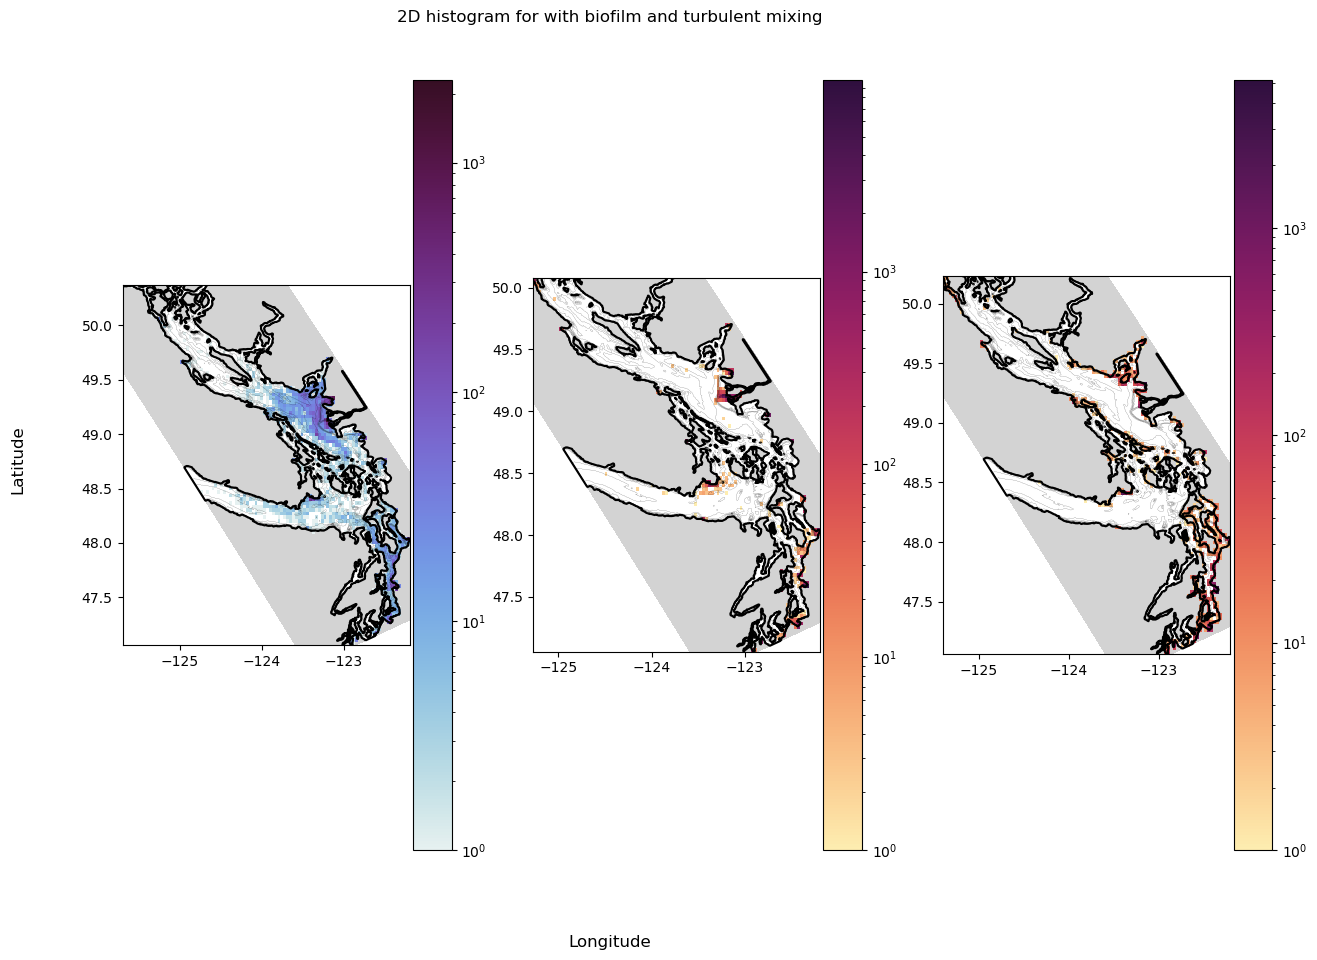

In [14]:
cm = cmocean.cm.dense

fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15, 10))
ax1.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax1.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax1.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

ax2.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax2.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax2.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

ax3.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax3.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax3.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')


aa=ax1.hist2d(Collon,Collat,100,norm = colors.LogNorm(), cmap =cm)
cb2=fig.colorbar(aa[3],ax=ax1,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15
#ax1.set_xlim([-124,-123])
#ax1.set_ylim([48,50])


aa2=ax2.hist2d(Sedlon,Sedlat,100,norm = colors.LogNorm(), cmap =cmocean.cm.matter)
#ax2.set_xlim([-124,-123])
#ax2.set_ylim([48,50])
cb2=fig.colorbar(aa2[3],ax=ax2,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15

aa=ax3.hist2d(Belon,Belat,100,norm = colors.LogNorm(), cmap =cmocean.cm.matter)
cb2=fig.colorbar(aa[3],ax=ax3,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15
#ax3.set_xlim([-124,-123])
#ax3.set_ylim([48,50])

#ax1.set_xticks(np.arange(-125, -122, step=1))
#ax2.set_xticks(np.arange(-125, -122, step=1))
#ax3.set_xticks(np.arange(-125, -122, step=1))
ax1.set_aspect(1/np.sin(np.deg2rad(49)))
ax2.set_aspect(1/np.sin(np.deg2rad(49)))
ax3.set_aspect(1/np.sin(np.deg2rad(49)))


fig.suptitle(f'2D histogram for with biofilm and turbulent mixing',y=0.95,x=0.45)
fig.supxlabel('Longitude',x=0.45)
fig.supylabel('Latitude',x=0.05)
#plt.savefig("/home/jvalenti/MOAD/2dhist.pdf")

In [15]:
DS=ds.to_dataframe()
dss=DS[DS.beached==0]## In the water column
dssla=np.array(dss.lat)
dsslo=np.array(dss.lon)
dsscon= np.array(dss.tau)
dssdep=np.array(dss.z)

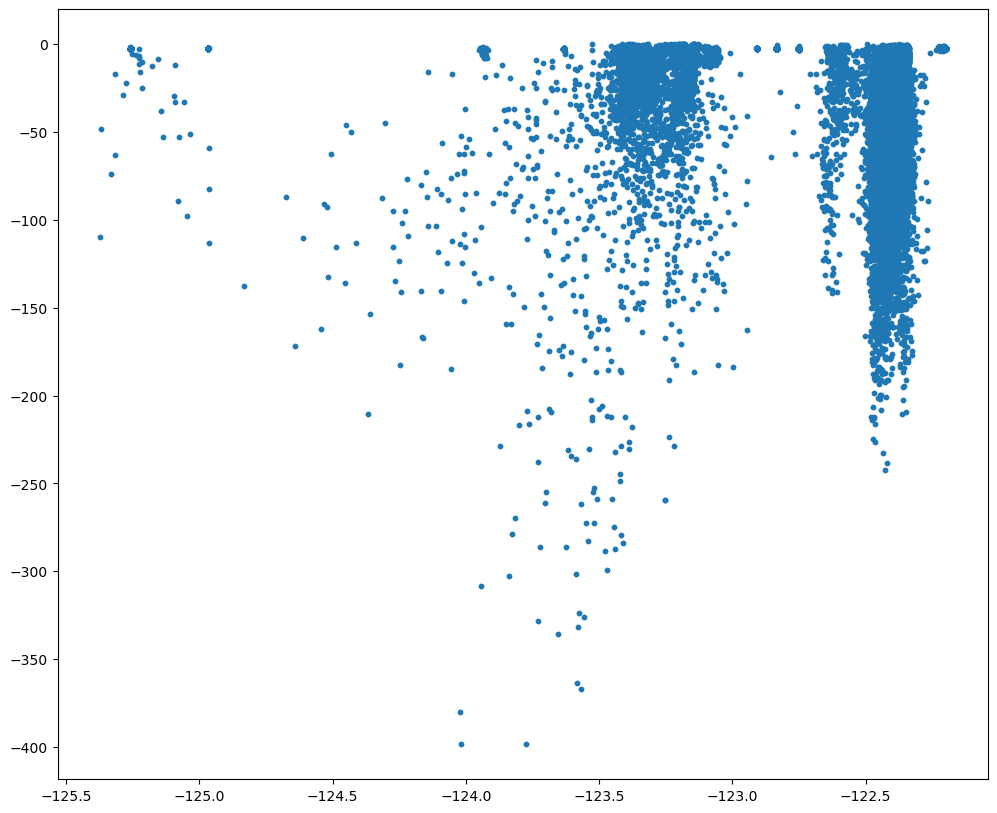

In [17]:
# #Green Particles are on the sediment
fig, axs = plt.subplots(1,figsize=(12, 10))
#ax = fig.add_subplot(projection='3d')
#visuald(axs[:,0],outfile,N,n,clon,clat,dmin,dd,300,301,local)
#visuald(fig,axs[:,1],outfile,N,n,clon,clat,dmin,dd,5039,5040,local)
nmin=-30
nmax=-1
coords,mask,ds = output(outfile,local)
ds0=ds.where(ds.time<=ds.time[0,nmax])
ds2=ds0.where(ds0.time>=ds0.time[0,nmin])
dss=ds2.where(ds2.beached==1)
dsc=ds2.where(ds2.beached==0)
dsb=ds2.where(ds2.beached==2)
zc=np.array(-dss.z[:, 0:-1])
zc = zc[~np.isnan(zc)]
axs.scatter(dsc.lon[:, 0:-1] ,-dsc.z[:, 0:-1],s=10,zorder=2)
#plt.plot(dss.lon[:,0:-1],)
#fig.suptitle(f'Particle location for  biofilm and turbulent mixing',y=0.95,x=0.45)
#fig.supxlabel('Longitude',x=0.45)
#axs.set_xlim([10000,12000])
#ax.set_ylim([47.9,50.5])
#ax.set_zlim([-400,0])

In [64]:
# import plotly.graph_objects as go
# import plotly.express as px

# z = np.array(-mask.mbathy[0,:,:]).flatten(order='C')
# #sh_0, sh_1 = z.shape
# #x, y = np.linspace(-125.5,-122, sh_1), np.linspace(47.9,50.5, sh_0)
# x = np.array(coords.glamt).flatten(order='C')
# y = np.array(coords.gphit).flatten(order='C')

# fig = go.Figure(data=[go.Surface(z=z, x=x, y=y,colorscale='deep',reversescale=True)])

# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                 project_z=True))
# fig.update_layout(title='Salish Sea Bathymetry',xaxis_title="Longitude", 
#                   yaxis_title="Latitude",autosize=False,
#                   width=900, height=900, 
#                   margin=dict(l=65, r=50, b=65, t=90))
# fig.update_layout(scene = dict(
#                     xaxis_title='Longitude',
#                     yaxis_title='Latitude',
#                     zaxis_title='Elevation'),
#                     margin=dict(r=60, b=60, l=60, t=60))  
# # fig.update_layout(color='Elevation')
# fig.update_layout(coloraxis_colorbar=dict(
#     title="Elevation",
#     thicknessmode="pixels", thickness=50,
#     lenmode="pixels", len=200,
#     yanchor="top", y=1,
#     ticks="outside", ticksuffix="",
#     dtick=5
# ))
# fig.update_layout(scene_aspectmode='manual',
#                   scene_aspectratio=dict(x=1, y=1, z=0.1))

# DSS=dss.to_dataframe()
# DSS=DSS[DSS.beached==3]

# #fig.add_scatter3d(z = -DSS.z/10,x=DSS.lon, y=DSS.lat, mode='markers', 
# #                   marker=dict(size=2))
# fig.show()

In [65]:
#profile(N,n,100,outfile,local)

In [66]:
# anim=mapanimationd(outfile,N,n,clon,clat,24,0)
# f = r"/home/jvalenti/MOAD/animations/fibreS1.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [16]:
def mapanimation(outfile,N,n,clon,clat,fps=1,local=1):
    '''mapanimation(outfile,N,n,clon,clat,fps=1,local=1)
    Use this function to return an animated map of the particles,
    keep local=1 when working local and = 0 when remote. 
    outfile is the name of the output file from OP
    N= number of deploying sites,n=number of particles oper location,
    clat,clon location of deploying locations.
    '''
    coords,mask,ds = output(outfile,local)
    fig = plt.figure(figsize=(19, 8))
    ax = plt.axes(xlim=(-127,-121),ylim=(46.8,51.2))
    ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
    ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.grid()
    ax.set_aspect(1/1)
    plt.ylabel('Latitude',fontsize=16)
    plt.xlabel('Longitude',fontsize=16)
    t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
    t.set_text('')
    ss = []#scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)
    sed= {0: "w", 1: "k"}

    def update(frame):
        tstamp = ds.time[0, frame].values.astype('datetime64[s]').astype(datetime)
        t.set_text(f'particle age: {frame/24:.2f} days')
        global ss
        for scat in ss:
            scat.remove()
        ss = scatter_particles(ax, N,n, frame,frame, ds.lat,ds.lon)
        #ss.append(ax.scatter(ds.lon[:,frame], ds.lat[:,frame],c='m',s=5,alpha=ds.beached[:,frame].fillna(0))/3)
        #ss.append(ax.scatter(clon,clat,c='r', marker='*', linewidths=2))
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps))

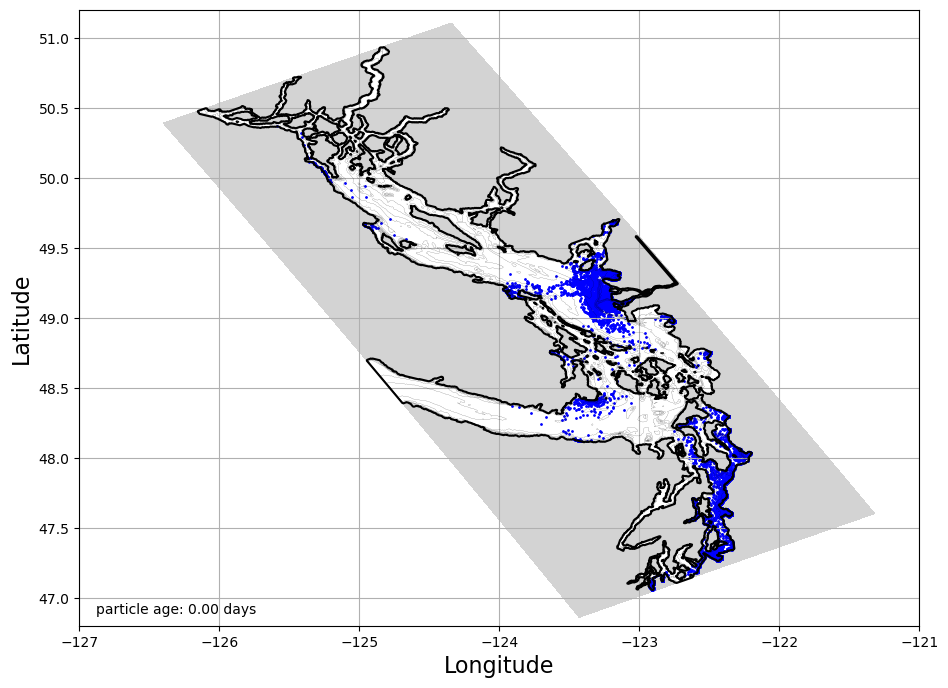

In [17]:
fps=1
anim = mapanimation(outfile,N,n,clon,clat,fps,local)
f = r"/home/jvalenti/MOAD/animations/fibreSStest.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)

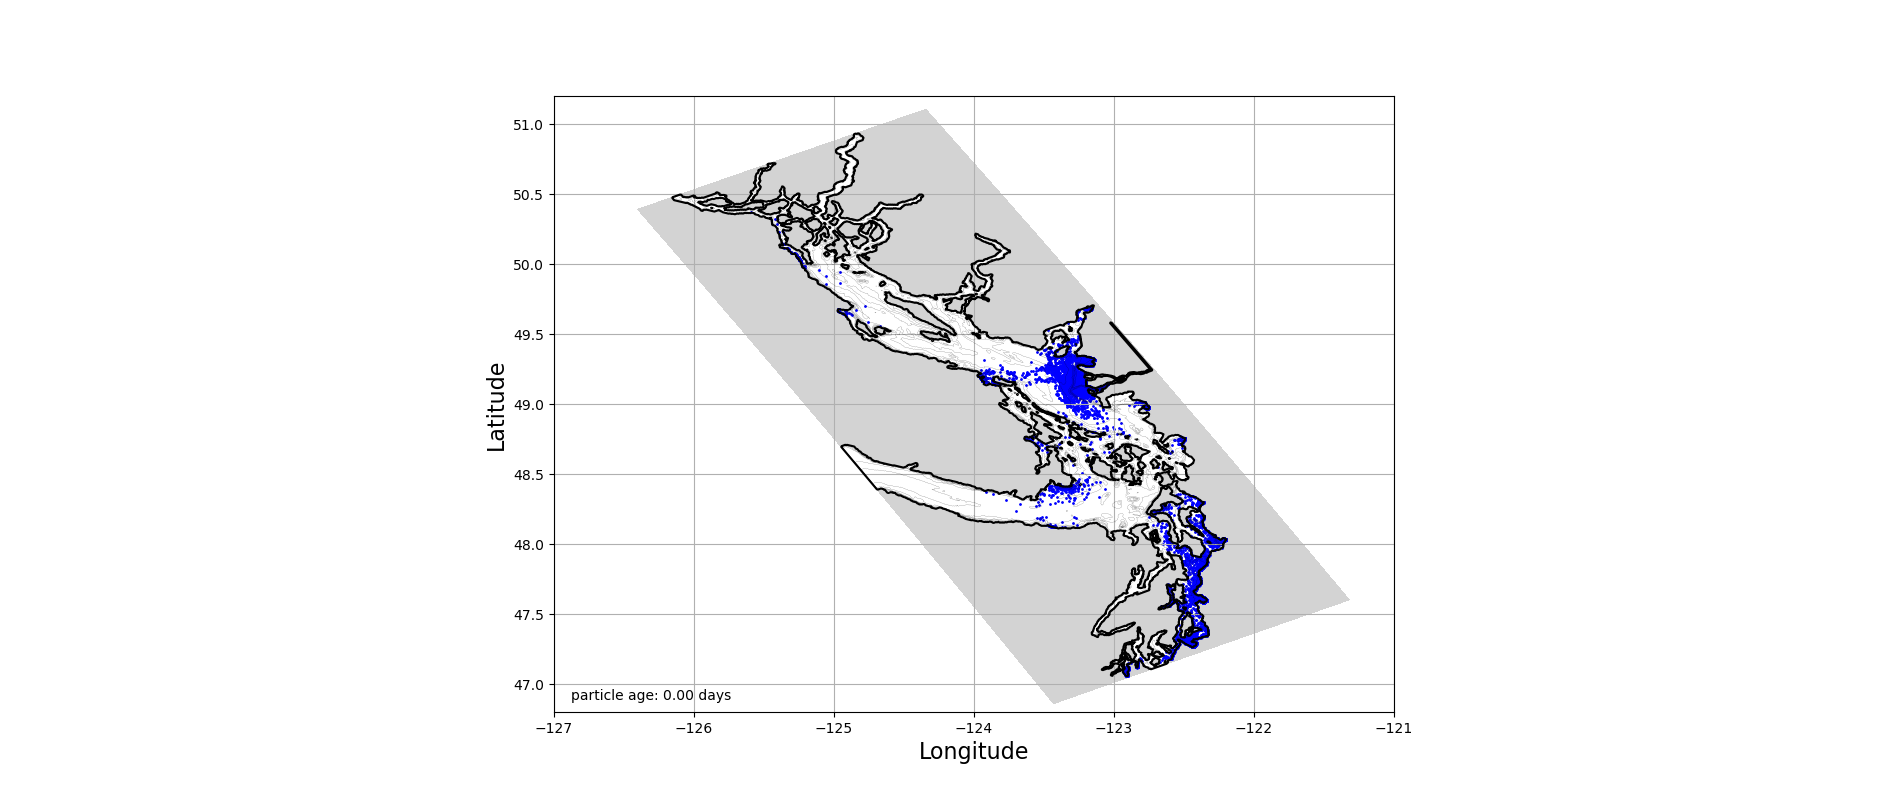

In [18]:
with open(f,'rb') as anim:
  display(Image(anim.read()))

In [37]:
def load_config(config_yaml):
   with open(config_yaml) as f:
       config = yaml.safe_load(f)
   return config

def loadyamls(config):
    param = load_config(config)
    start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
    Tmax = param['param']['length'] # Set Time length [days] 
    duration = timedelta(days=Tmax)
    dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
    N = param['param']['N'] # number of deploying locations
    n = param['param']['n'] # 1000   # number of particles per location
    dmin = param['param']['dmin'] #minimum depth
    dd = param['param']['dd'] #max depth difference from dmin
    name = param['file']['name'] #name output file
    daterange = [start+timedelta(days=i) for i in range(Tmax)]
    fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
    outfile = os.path.join(paths['out'], fn)
    MFc = param['param']['MFc']
    return outfile, MFc

In [54]:
# outfile , MFc=loadyamls(config)
# coords=xr.open_dataset(paths['coords'],decode_times=False)
# ds = xr.open_dataset(outfile)
# DS=ds.to_dataframe()
# time=np.array(DS.xs(0, level='traj').iloc[:,3])
# mask = xr.open_dataset(paths['mask'])
# conc=np.zeros((coords.nav_lon.shape[0],coords.nav_lon.shape[1],mask.gdepw_0.shape[1]))
# jjii = xr.open_dataset('~/MOAD/grid/grid/grid_from_lat_lon_mask999.nc')
# arr = mask.gdepw_0[0,:,240,340]
# dss=DS[DS.beached==0]## In the water column
# dssla=np.array(dss.lat)
# dsslo=np.array(dss.lon)
# dsscon = float(MFc)
# dssdep=np.array(dss.z)

# for i in range(len(dss)):
#     if i%1e3==0:
#         print(f'{100*i/len(dss):.2f}% done.')
#     jj = jjii.jj.sel(lats=dssla[i], lons=dsslo[i], method='nearest').item()
#     ii = jjii.ii.sel(lats=dssla[i], lons=dsslo[i], method='nearest').item()
#     try:
#         dep = (np.abs(arr - dssdep[i])).argmin()
#         if arr[dep] > dssdep[i]:
#             dep+=-1
#         conc[jj,ii,dep] += dsscon
#     except ValueError:
#         pass
    
# data_set=xr.Dataset(coords={'lat': (['x', 'y'], coords.nav_lat.data),
#                 'lon': (['x', 'y'], coords.nav_lon.data),'depth':arr})
# data_set["Prob"]=(['x', 'y','z'], conc)
# param = load_config(config)
# data_set.load().to_netcdf(path='/home/jvalenti/MOAD/results/'+param['file']['name']+'_prob'+str(param['startdate']['year'])+'.nc')

In [55]:
conc=xr.open_dataarray('/home/jvalenti/MOAD/results/Salish2018_150_prob2018.nc')

In [102]:
mascara = mask.umask[0,0,:,:]

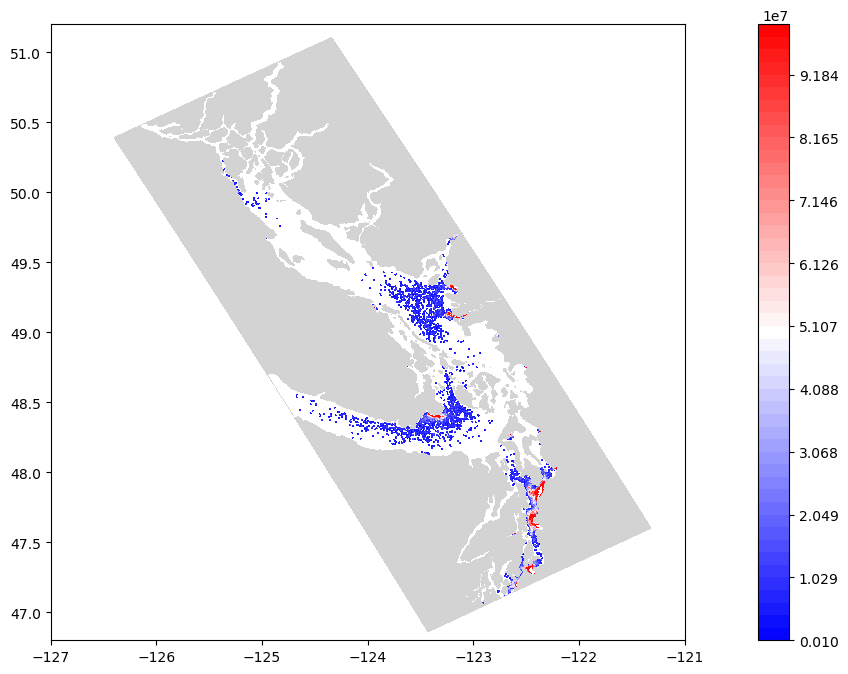

In [131]:
fig = plt.figure(figsize=(19, 8))
#axs = plt.axes(xlim=(-123.25,-122.8),ylim=(49,49.25))
axs=plt.axes(xlim=(-127,-121),ylim=(46.8,51.2))
plot = np.sum(conc[:,:,:], axis = 2)

levels = np.linspace(1e5,1e8,50)

colors = list(cmocean.cm.dense(np.linspace(0,1,len(levels)-1)))
colors[-1] = "red"
cmap = matplotlib.colors.ListedColormap(colors,"", len(colors))


# #axs.contourf(coords.nav_lon, coords.nav_lat, mask.bathym[0,:,:],levels=np.arange(0,400,10),cmap=cmocean.cm.deep,alpha=1)
a=axs.contourf(coords.nav_lon, coords.nav_lat, plot,levels=levels,cmap='bwr')
 #axs.scatter(frs_lon,frs_lat)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')

# #axs.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
plt.colorbar(a)

axs.set_aspect(1/np.sin(np.deg2rad(49)))

In [148]:
vol=xr.open_dataset('/home/jvalenti/MOAD/grid/grid/mesh_maskBV201702.nc')['volume_cell']
def get_conc(latmin,latmax,lonmin,lonmax, conc):
    jjii = xr.open_dataset('~/MOAD/grid/grid/grid_from_lat_lon_mask999.nc')
    j = [jjii.jj.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    i = [jjii.ii.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    j.append(jjii.jj.sel(lats=latmin, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmin, lons=lonmax, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmin, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmin, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmax, method='nearest').item())
    a=[min(j),max(j),min(i),max(i)]
    Len = (a[1]-a[0])*(a[3]-a[2])
    SD = []
    Mean = []
    for ki in range(len(z)):
        values = []
        vols = []
        for j in range(a[0],a[1],1):
            for i in range(a[2],a[3],1):
                values.append(conc[j,i,ki])
                vols.append(vol[0,ki,j,i])
        values = np.array(values)
        vols = np.array(vols)
        Mean.append(np.sum(values)/np.sum(vols))
        valuess = np.divide(values,vols)
        SD.append(np.std(valuess)/np.sqrt(Len))
    return Mean,SD
def MP_measure(conc):
    Fraser_MP,Fraser_SE=get_conc(49.1,49.13,-123.2,-123.16,conc)
    SoG_MP,SoG_SE =get_conc(49.2,49.3,-123.5,-123.7,conc)
    Lori_MP,Lori_SE =get_conc(49.1,49.36,-123.3,-123.2,conc)
    return Fraser_MP,Fraser_SE, Lori_MP,Lori_SE,SoG_MP,SoG_SE
z = mask.gdepw_0[0,:,240,340]

F1,FE1,L1,LE1,S1,SE1=MP_measure(conc)
dict = {'F1':F1,'FE1':FE1,'L1':L1,'LE1':LE1,'S1':S1,'SE1':SE1}
df = pd.DataFrame(dict) 
df.to_csv('resultsSalishS.csv')

KeyboardInterrupt: 

In [159]:
def MP_measur(ax,RES):
    Fraser_MP = RES.iloc[:,0]
    Fraser_SE = RES.iloc[:,1]
    Lori_MP = RES.iloc[:,2]
    Lori_SE = RES.iloc[:,3]
    SoG_MP = RES.iloc[:,4]
    SoG_SE = RES.iloc[:,5]
    label = ["We'll see"]
    ax[1].errorbar(Lori_MP, -z, xerr = Lori_SE,label=label)
    ax[0].errorbar(Fraser_MP, -z, xerr = Fraser_SE,label=label)
    ax[2].errorbar(SoG_MP, -z, xerr = SoG_SE,label=label)
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    #ax[0].set_ylim(-20,0.5)
    #ax[1].set_ylim(-20,0.5)
    #ax[2].set_ylim(-20,0.5)
    return 

Text(0.5, 1.0, 'MP concentration in the SoG')

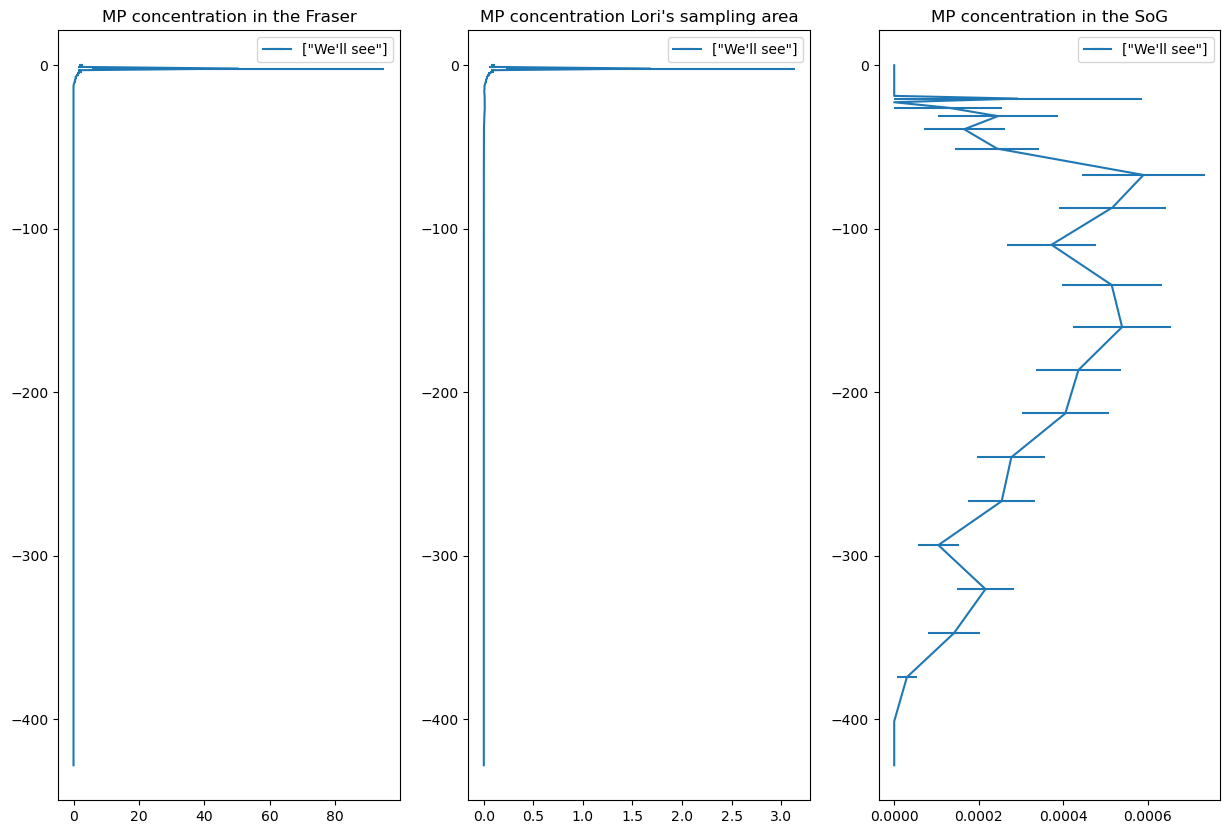

In [163]:
RES = pd.read_csv('resultsSalishS.csv',index_col=[0])/50
fig,axs=plt.subplots(1,3,figsize=(15,10))
MP_measur(axs,RES)
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[2].set_title('MP concentration in the SoG')

In [188]:
DS.tau.min()

0.0

Text(0.5, -0.05, 'Longitude')

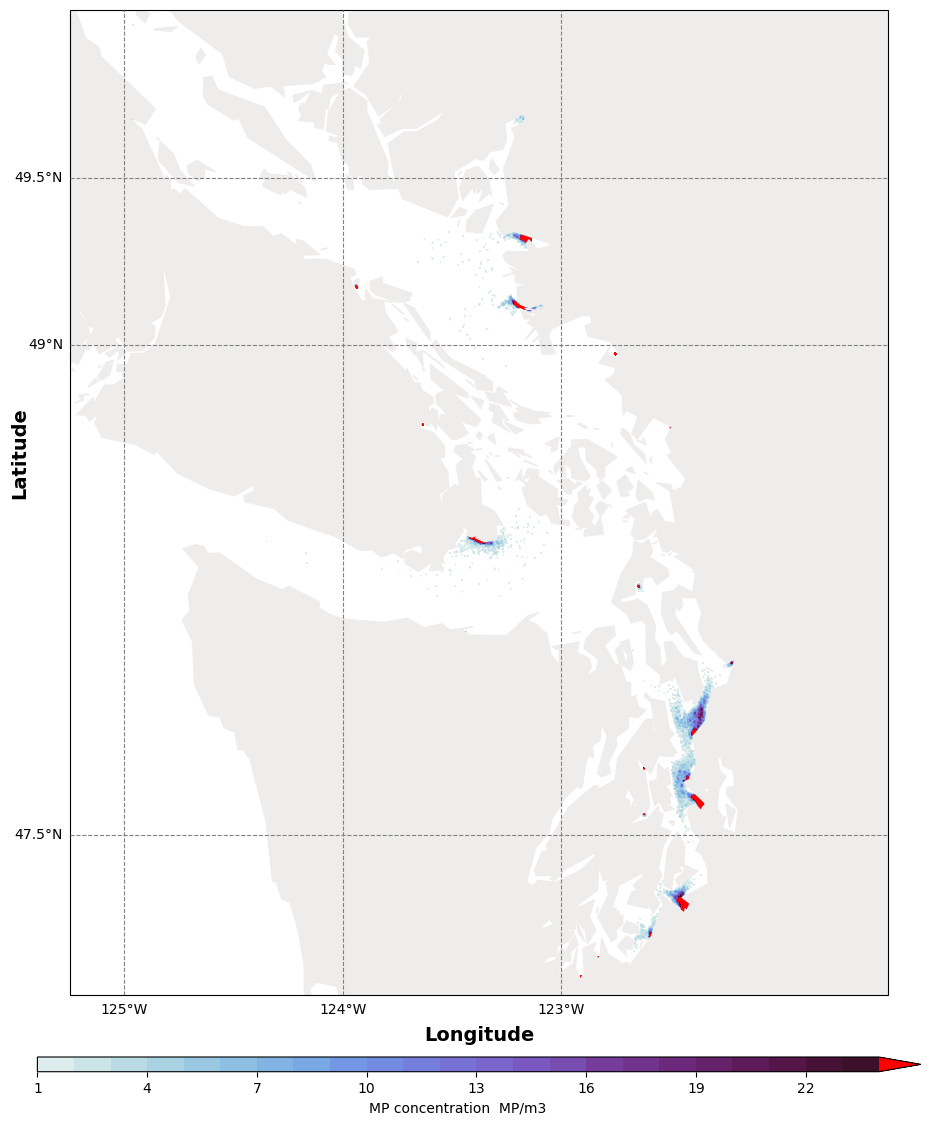

In [190]:
# Make map
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(38, 16), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([-125.25, -121.5, 47, 50], crs=crs.PlateCarree())

ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#EEEDEC',edgecolor='#EEEDEC'),zorder=2)
im=ax.contourf(coords.nav_lon, coords.nav_lat, np.sum(conc[:,:,:], axis = 2)/12.5e6,transform=crs.PlateCarree(),levels=np.arange(1,25,1),cmap=cmap,extend='max')

gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=[-125,-124,-123,-121], ylocs=[47.5,49,49.5],zorder=5)
gl.top_labels, gl.right_labels = False, False

cbar = fig.colorbar(im, location='bottom',aspect=60,shrink=0.3,pad=0.05)

cbar.set_label('MP concentration  MP/m3')

# ax.add_patch(mpatches.Rectangle(xy=[-124,49.3], width=0.2, height=0.1,
#                                     facecolor=(245/255, 255/255, 40/255),
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
#                  )
# ax.add_patch(mpatches.Rectangle(xy=[-123.3,49.1], width=0.1, height=0.26,
#                                     facecolor='green',
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
#                  )
# ax.add_patch(mpatches.Rectangle(xy=[-123.2,49.1], width=0.04, height=0.03,
#                                     facecolor='black',
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
#                  )

# ax.add_patch(mpatches.Rectangle(xy=[-123.5,48.25], width=0.2, height=0.1,
#                                     facecolor='black',
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
#                  )

# ax.add_patch(mpatches.Rectangle(xy=[-123.35,48.5], width=0.2, height=0.1,
#                                     facecolor='black',
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
                #  )

ax.text(-0.05, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")
ax.text(0.5, -0.05, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")